## Prediction steps:

1.  Target Variable: we will use 'price' as the target variable for prediction.

2.  Feature Selection: Assess the correlation of different columns with the target variable to decide which ones to use as features.
3. Model Selection: we will use Decision Trees for the model.

4. Data Splitting and Prediction: Using data from 1995-2020 for training the model and predict prices for 2021 and 2022. Then, we'll compare these predictions with the actual data for those years.

In [27]:
import pandas as pd

In [28]:
df_mra = pd.read_csv('/content/drive/MyDrive/food-cost-planner Project/prediction_price/national_MRA_clean.csv')

In [29]:
df_mra.head(5)

,date,location,vectorid,price,product,unit_quantity,unit,category
0,1995-01-01,Canada,v735165,10.17,Round steak,1.0,kilogram,Protein
1,1995-01-01,Canada,v735176,11.25,Sirloin steak,1.0,kilogram,Protein
2,1995-01-01,Canada,v735187,12.08,Prime rib roast,1.0,kilogram,Protein
3,1995-01-01,Canada,v735198,7.23,Blade roast,1.0,kilogram,Protein
4,1995-01-01,Canada,v735209,7.12,Stewing beef,1.0,kilogram,Protein


## Data Preprocessing Class (Preprocessor)

In [30]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

class Preprocessor:
    def __init__(self, filepath):
        self.data = pd.read_csv(filepath)

    def remove_outliers(self, column):
        Q1 = self.data[column].quantile(0.25)
        Q3 = self.data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        self.data = self.data[(self.data[column] >= lower_bound) & (self.data[column] <= upper_bound)]
        print(f"Outliers removed from {column}")

    def encode_categorical(self):
        label_encoder = LabelEncoder()
        self.data['product_encoded'] = label_encoder.fit_transform(self.data['product'])
        self.data['category_encoded'] = label_encoder.fit_transform(self.data['category'])
        print("Categorical variables encoded.")

    def convert_to_datetime(self, column):
        self.data[column] = pd.to_datetime(self.data[column])
        print(f"Converted {column} to datetime format.")

    def extract_date_features(self, column):
        self.data['year'] = self.data[column].dt.year
        self.data['month'] = self.data[column].dt.month
        self.data['day'] = self.data[column].dt.day
        print(f"Extracted date features from {column}.")

    def show_insights(self):
        print(self.data.head())
        print("\nData Types:\n", self.data.dtypes)
        print("\nMissing Values:\n", self.data.isnull().sum())

    def get_preprocessed_data(self):
        return self.data



preprocessor = Preprocessor('/content/drive/MyDrive/food-cost-planner Project/prediction_price/national_MRA_clean.csv')  # Replace with your file path

# Remove outliers from a price column
preprocessor.remove_outliers('price')

# Encode categorical variables
preprocessor.encode_categorical()

# Convert 'date' column to datetime
preprocessor.convert_to_datetime('date')
preprocessor.extract_date_features('date')
# Display insights of the preprocessed data
preprocessor.show_insights()

preprocessed_data = preprocessor.get_preprocessed_data()

Outliers removed from price
Categorical variables encoded.
Converted date to datetime format.
Extracted date features from date.
        date location vectorid  price       product  unit_quantity      unit  \
3 1995-01-01   Canada  v735198   7.23   Blade roast            1.0  kilogram   
4 1995-01-01   Canada  v735209   7.12  Stewing beef            1.0  kilogram   
5 1995-01-01   Canada  v735220   3.73   Ground beef            1.0  kilogram   
6 1995-01-01   Canada  v735221   8.36    Pork chops            1.0  kilogram   
7 1995-01-01   Canada  v735222   4.90    Butt roast            1.0  kilogram   

  category  product_encoded  category_encoded  year  month  day  
3  Protein                5                 7  1995      1    1  
4  Protein               42                 7  1995      1    1  
5  Protein               24                 7  1995      1    1  
6  Protein               34                 7  1995      1    1  
7  Protein                7                 7  1995      1  

## 2-Data Visualization Class (DataViz)

<ipython-input-31-343dcc91b58c>:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(self.data.corr(), annot=True, cmap='coolwarm')


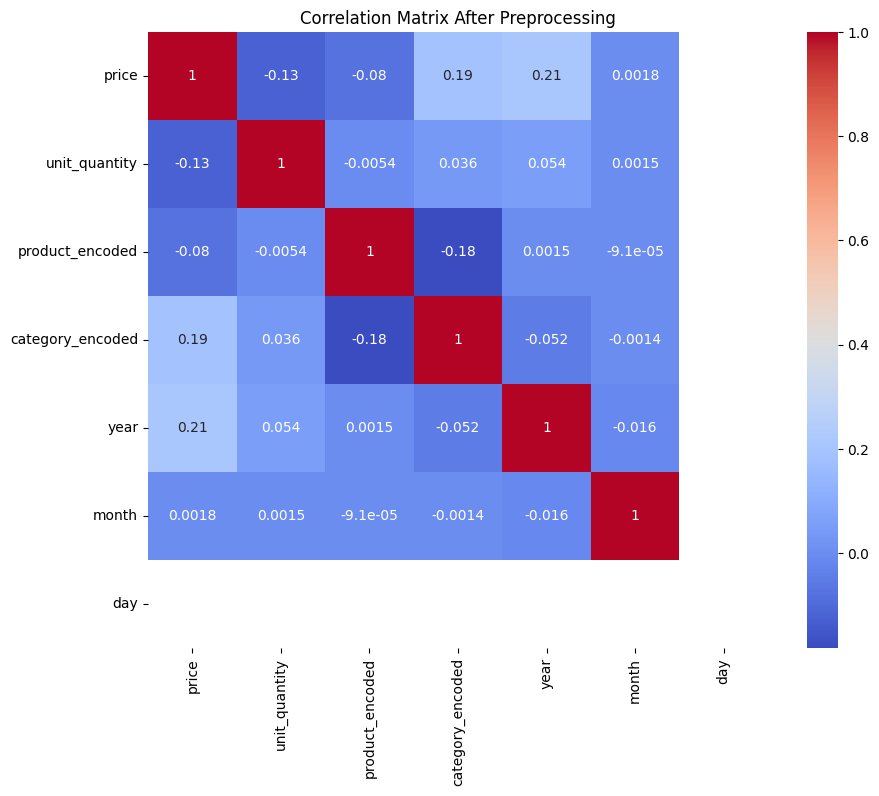

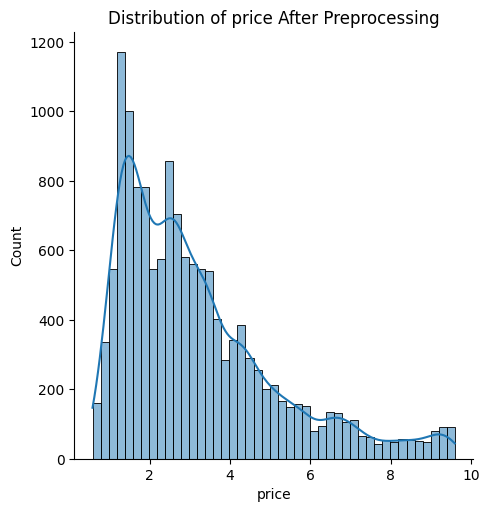

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

class DataViz:
    def __init__(self, preprocessed_data):
        self.data = preprocessed_data

    def plot_correlation(self):
        plt.figure(figsize=(10, 8))
        sns.heatmap(self.data.corr(), annot=True, cmap='coolwarm')
        plt.title('Correlation Matrix After Preprocessing')
        plt.show()

    def plot_distribution(self, column):
        sns.displot(self.data, x=column, kde=True)
        plt.title(f'Distribution of {column} After Preprocessing')
        plt.show()


#usage

# instance of DataViz with the preprocessed data from previous class
viz = DataViz(preprocessed_data)

# Plot the correlation matrix and Plot the distribution of price column
viz.plot_correlation()
viz.plot_distribution('price')


# Comment ⁉

Weak Correlations: The low absolute values indicate that there are no strong linear correlations between the variables w're analyzing. This is typical because the dataset contains a lot of unique categorical data.

In [32]:
import statsmodels.api as sm
from statsmodels.formula.api import ols



# ANOVA for 'product_encoded'
model_product = ols('price ~ C(product_encoded)', data=preprocessed_data).fit()
anova_results_product = sm.stats.anova_lm(model_product, typ=2)
print('ANOVA results for product_encoded:\n', anova_results_product, '\n')

# ANOVA for 'category_encoded'
model_category = ols('price ~ C(category_encoded)', data=preprocessed_data).fit()
anova_results_category = sm.stats.anova_lm(model_category, typ=2)
print('ANOVA results for category_encoded:\n', anova_results_category, '\n')

# two-way ANOVA to see interaction effects
model_interaction = ols('price ~ C(product_encoded) * C(category_encoded)', data=preprocessed_data).fit()
anova_results_interaction = sm.stats.anova_lm(model_interaction, typ=2)
print('ANOVA results with interaction effect:\n', anova_results_interaction)


ANOVA results for product_encoded:
                           sum_sq       df            F  PR(>F)
C(product_encoded)  44111.229430     47.0  1419.381917     0.0
Residual             9277.707169  14031.0          NaN     NaN 

ANOVA results for category_encoded:
                            sum_sq       df           F  PR(>F)
C(category_encoded)  13083.260474      8.0  570.891908     0.0
Residual             40305.676125  14070.0         NaN     NaN 

ANOVA results with interaction effect:
                                                sum_sq       df            F  \
C(product_encoded)                       47239.947470     47.0  1520.055734   
C(category_encoded)                               NaN      8.0          NaN   
C(product_encoded):C(category_encoded)  387379.126885    376.0  1558.103614   
Residual                                  9277.707169  14031.0          NaN   

                                        PR(>F)  
C(product_encoded)                         0.0  
C(category_

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 47, but rank is 11
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1917: RuntimeWarning: invalid value encountered in divide
  F /= J
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 376, but rank is 36
  warnings.warn('covariance of constraints does not have full '




Comment :

Significant Differences by Product:

The p-value for product_encoded in the one-way ANOVA is extremely low , suggesting that there are statistically significant differences in the average price among the different products.

Significant Differences by Category:

Similarly, the p-value for category_encoded is also extremely low, indicating significant differences in the average price across the different categories.
Significant Interaction Effect:

The interaction effect between product_encoded and category_encoded has a very low p-value, indicating that the effect of product on price is not consistent across categories and vice versa.

## 3.Model Training and Testing Class (ModelTrainer)

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

class ModelTrainer:
    def __init__(self, data, features, target):
        self.data = data
        self.features = features
        self.target = target
        self.model = DecisionTreeRegressor()

    def split_data(self):
        train_data = self.data[self.data['date'].dt.year <= 2020]
        test_data = self.data[self.data['date'].dt.year >= 2021]
        self.X_train = train_data[self.features]
        self.y_train = train_data[self.target]
        self.X_test = test_data[self.features]
        self.y_test = test_data[self.target]
        print("Data split into training and testing sets.")

    def train_and_evaluate(self):
        self.model.fit(self.X_train, self.y_train)
        predictions = self.model.predict(self.X_test)
        mse = mean_squared_error(self.y_test, predictions)
        rmse = mse ** 0.5
        print(f"Model RMSE: {rmse}")


#usage

features = ['year', 'month', 'day', 'product_encoded', 'unit_quantity', 'category_encoded']
target = 'price'
trainer = ModelTrainer(preprocessed_data, features, target)
trainer.split_data()  # Splitting the data
trainer.train_and_evaluate()

Data split into training and testing sets.
Model RMSE: 0.32921161956472844


Comment ⁉
The Root Mean Squared Error (RMSE) of 0.3292 for the model indicates the typical deviation of the predicted price from the actual price values in the test dataset. the price values are generally close to 1 (e.g., in the range of 0 to 10), an RMSE of 0.3292 would be more significant like the distribution plot explain ,so we are suggesting that there's more room for improvement in the model's predictions, that's way i will conduct more steps to improve the result .

In [36]:
# Calculate the mean price as a baseline prediction
baseline_pred = preprocessed_data['price'].mean()

# Calculate RMSE for the baseline
baseline_rmse = mean_squared_error(preprocessed_data['price'], [baseline_pred] * len(preprocessed_data), squared=False)
print(f"Baseline RMSE: {baseline_rmse}")

Baseline RMSE: 1.947330790729144


The Baseline RMSE of 1.9473 compared to the model's RMSE of 0.3292 indicates that our model is performing significantly better than a simple baseline model that always predicts the mean price. This is a positive outcome, suggesting that the model has learned meaningful patterns from the data and is providing predictions that are substantially more accurate than a naive guess.

Here's what we can infer from this comparison:

Model's Effectiveness: The substantial improvement in RMSE from the baseline to our model shows that the features we have selected and the decision tree algorithm are effectively capturing the underlying trends in our data.
Model Validation: Such an improvement provides validation that our model is learning from the data and is not simply replicating the average price.
Given this information, we can proceed with further diagnostics and optimizations, (like hyperparameter tuning and cross-validation).

## 4. Model Hyperparameter Tuning and Evaluation Class (ModelTuner)

In [37]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

class ExtendedModelTrainer(ModelTrainer):
    def __init__(self, data, features, target):
        super().__init__(data, features, target)
        self.best_model = None

    def hyperparameter_tuning(self):
        param_grid = {
            'max_depth': [3, 5, 10, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt', 'log2', None]
        }
        grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(self.X_train, self.y_train)
        self.best_model = grid_search.best_estimator_
        print(f"Best parameters: {grid_search.best_params_}")

    def cross_validate(self):
        cv_scores = cross_val_score(self.best_model, self.X_train, self.y_train, cv=5, scoring='neg_mean_squared_error')
        cv_rmse = np.sqrt(-cv_scores)
        print(f"Cross-Validation RMSE: {cv_rmse.mean()} ± {cv_rmse.std()}")

# Usage
features = ['year', 'product_encoded', 'unit_quantity', 'category_encoded']  # Adjust as per your dataset
target = 'price'


extended_trainer = ExtendedModelTrainer(preprocessed_data, features, target)
extended_trainer.split_data()  # Splitting the data
extended_trainer.hyperparameter_tuning()  # Hyperparameter tuning
extended_trainer.cross_validate()  # Cross-validation



Data split into training and testing sets.
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Cross-Validation RMSE: 0.39344197744885456 ± 0.05698098343773245


# comment ⁉
The results from our model training, hyperparameter tuning, and cross-validation provide valuable insights:


Best Hyperparameters:

max_depth: None (indicating the tree grow until all leaves are pure or contain less than min_samples_split samples)
max_features: 'sqrt' (the number of features to consider when looking for the best split is the square root of the total number of features)
min_samples_leaf: 1 (the minimum number of samples required to be at a leaf node)
min_samples_split: 2 (the minimum number of samples required to split an internal node)
These parameters are the best combination found by GridSearchCV for your Decision Tree model, optimizing for the lowest mean squared error.

Cross-Validation RMSE:

The cross-validation RMSE is approximately 0.3934, with a standard deviation of 0.0570. This metric is slightly higher than the initial RMSE of 0.3292 but provides a more robust estimate of the model's performance.
The standard deviation indicates some variation in model performance across different folds of the data, which is normal in cross-validation. It's a useful measure to understand the consistency of our model.

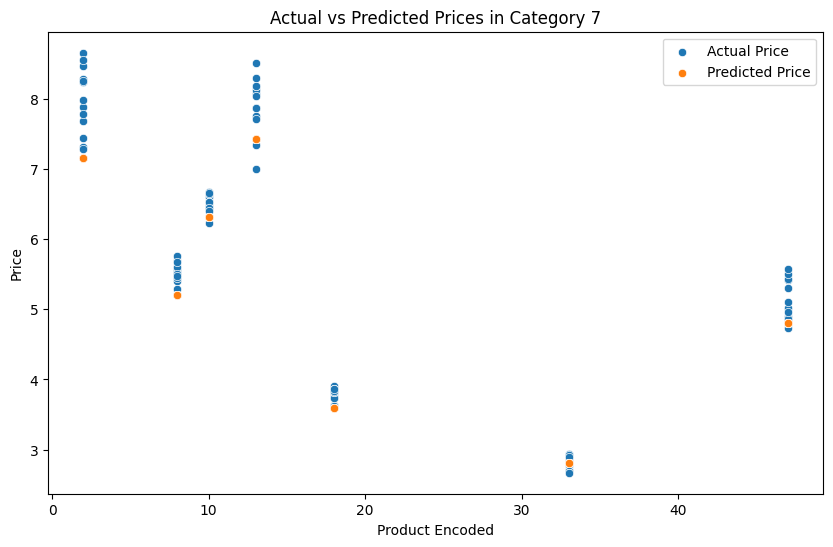

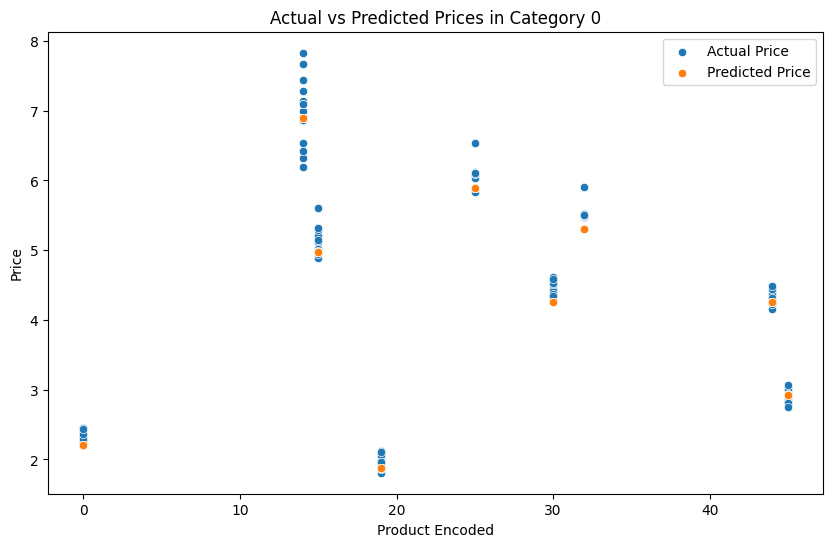

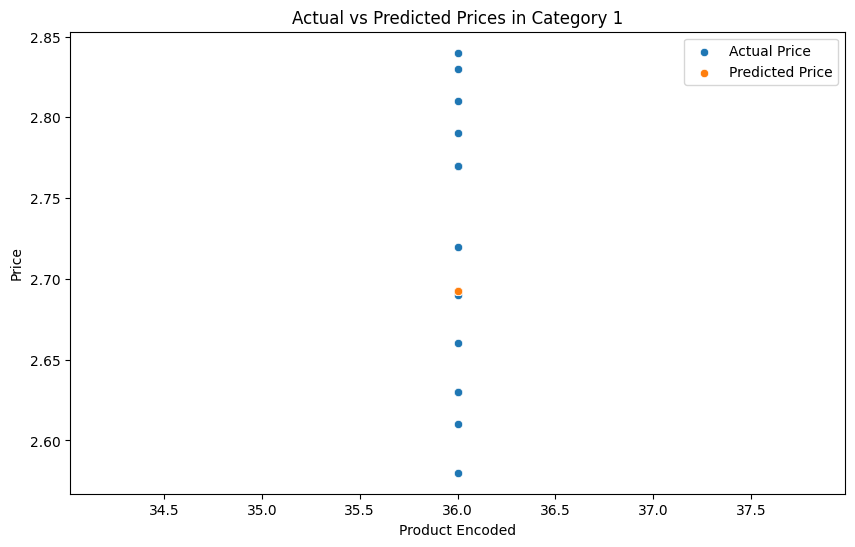

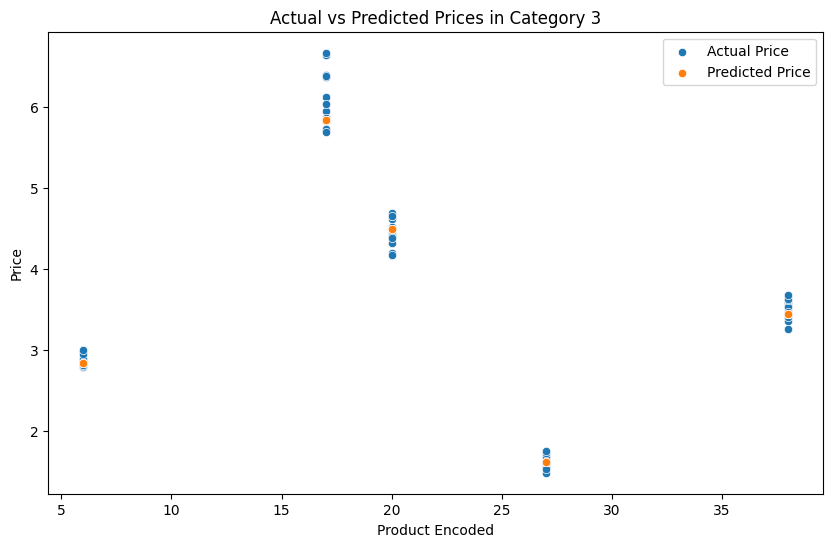

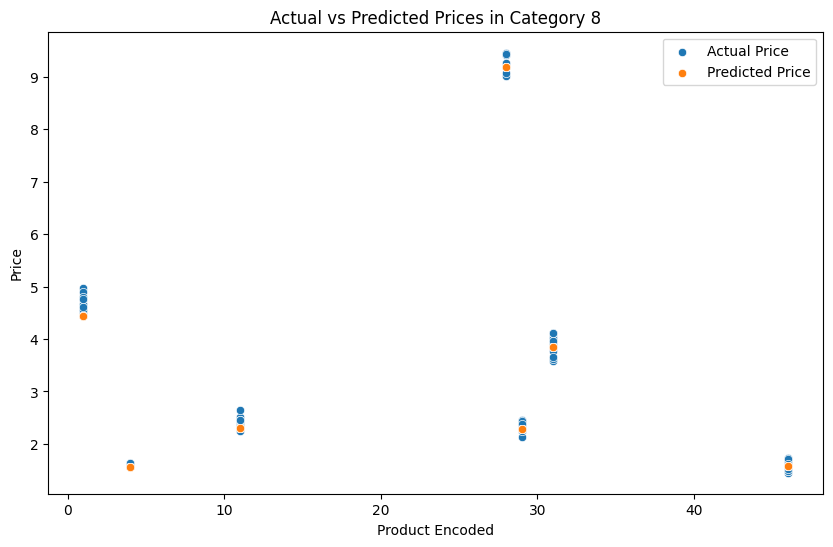

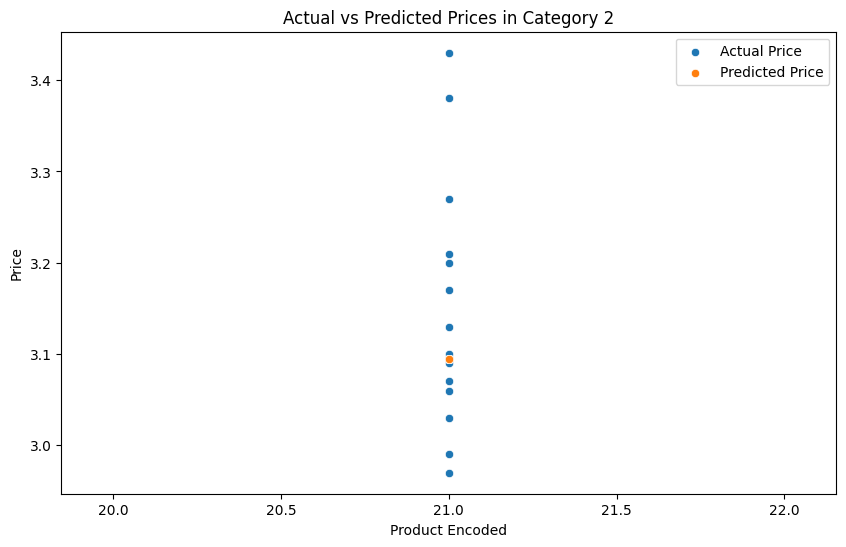

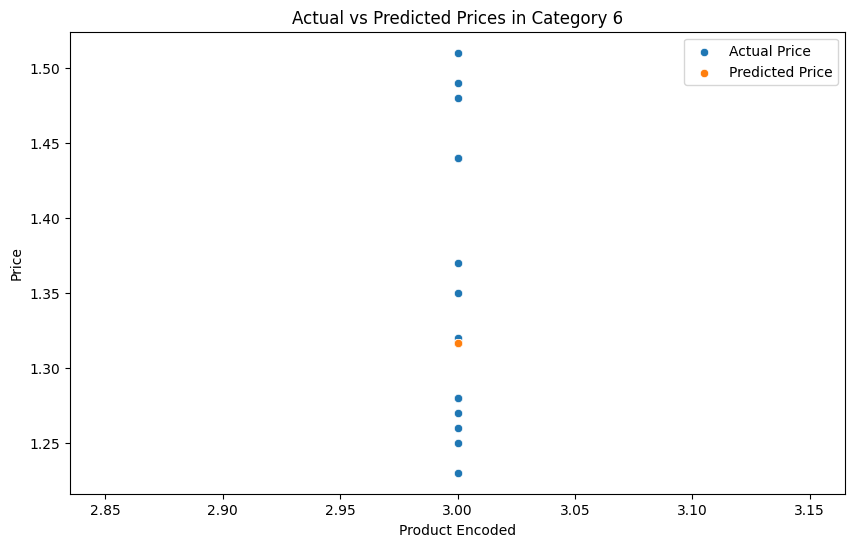

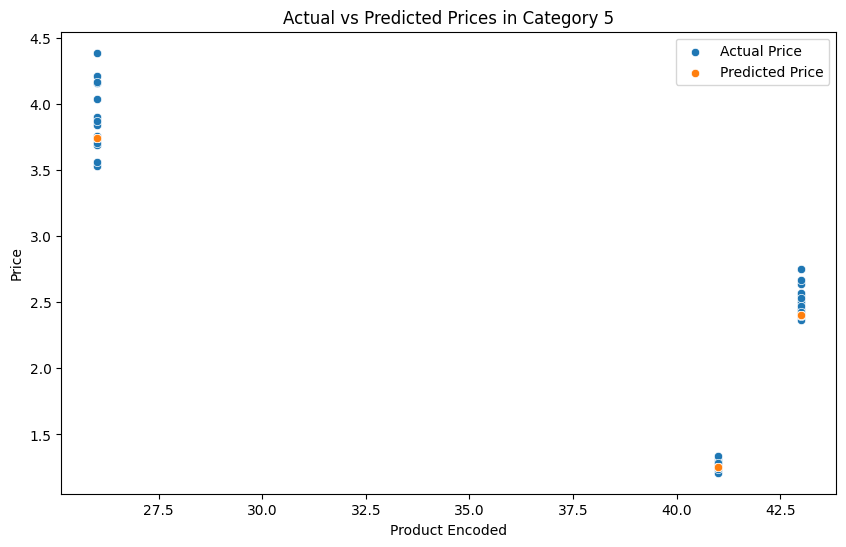

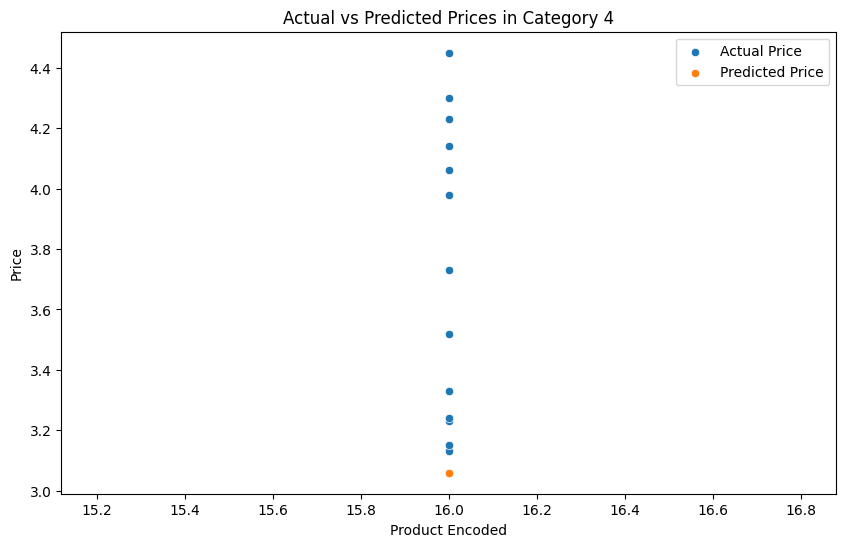

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

class ModelResultsPlotter:
    def __init__(self, model, X_test, y_test):
        self.model = model
        self.X_test = X_test
        self.y_test = y_test
        self.predictions = None

    def make_predictions(self):
        # Generate predictions
        self.predictions = self.model.predict(self.X_test)
        self.X_test['predicted_price'] = self.predictions

    def plot_results(self, product_col, category_col):
        # Merge predictions with actual prices
        results = self.X_test.copy()
        results['actual_price'] = self.y_test

        # Plot for each category
        categories = results[category_col].unique()
        for category in categories:
            plt.figure(figsize=(10, 6))
            category_data = results[results[category_col] == category]
            sns.scatterplot(data=category_data, x=product_col, y='actual_price', label='Actual Price')
            sns.scatterplot(data=category_data, x=product_col, y='predicted_price', label='Predicted Price')
            plt.title(f'Actual vs Predicted Prices in Category {category}')
            plt.xlabel('Product Encoded')
            plt.ylabel('Price')
            plt.legend()
            plt.show()

# Usage
plotter = ModelResultsPlotter(extended_trainer.best_model, extended_trainer.X_test, extended_trainer.y_test)
plotter.make_predictions()
plotter.plot_results('product_encoded', 'category_encoded')
